<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250107%5D%20FedAvg-DL%20with%20MLP-LSTM%20model%20on%20UNSW-NB15%20with%20early%20stopped_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FedAvg-DL // MLP-LSTM model 10 classes on UNSW-NB15**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
# Load dataset
dataset = pd.read_csv("Dataset_10Classes.csv") #UNSW-NB15 10 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,ID_Cb,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,Class
0,1,1,0.121478,tcp,-,FIN,6,4,258,172,...,1,0,0,0,1,1,0,Normal,0,0
1,2,2,0.649902,tcp,-,FIN,14,38,734,42014,...,2,0,0,0,1,6,0,Normal,0,0
2,3,3,1.623129,tcp,-,FIN,8,16,364,13186,...,3,0,0,0,2,6,0,Normal,0,0
3,4,4,1.681642,tcp,ftp,FIN,12,12,628,770,...,3,1,1,0,2,1,0,Normal,0,0
4,5,5,0.449454,tcp,-,FIN,10,6,534,268,...,40,0,0,0,2,39,0,Normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,257669,82328,0.000005,udp,-,INT,2,0,104,0,...,2,0,0,0,2,1,0,Normal,0,0
257669,257670,82329,1.106101,tcp,-,FIN,20,8,18062,354,...,1,0,0,0,3,2,0,Normal,0,0
257670,257671,82330,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0
257671,257672,82331,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0


**Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [93000  2677  2329 16353 44525 24246 58871 13987  1511   174]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [93000 93000 93000 93000 93000 93000 93000 93000 93000 93000]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**The hybrid MLP + LSTM model**

In [ ]:
from keras.regularizers import l2

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the hybrid MLP + LSTM model with regularization and other techniques to reduce overfitting
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # MLP layers with L2 regularization
    model.add(Dense(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Increased dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))

    # Dense layers for final feature extraction
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], )
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.8672 - loss: 0.7599 - val_accuracy: 0.9961 - val_loss: 0.2332
Epoch 2/50
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9687 - loss: 0.3113 - val_accuracy: 0.9919 - val_loss: 0.2303
Epoch 3/50
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9724 - loss: 0.2780 - val_accuracy: 0.9977 - val_loss: 0.1749
Epoch 4/50
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9738 - loss: 0.2647 - val_accuracy: 0.9982 - val_loss: 0.1693
Epoch 5/50
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9743 - loss: 0.2582 - val_accuracy: 0.9957 - val_loss: 0.1773
Epoch 6/50
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.9752 - loss: 0.2495 - val_accuracy: 0.9977 - val_loss: 0.1688
Epoch 7/50
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9762 - loss: 0.2464 - val_accuracy: 0.9966 - val_loss: 0.1675
Epoch 8/50
23250/23250 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9988602151
Precision: 0.9988623096
Recall: 0.9988602151
F1-Score: 0.9988602646


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

5813/5813 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Accuracy: 0.9988602151
Precision: 0.9988623096
Recall: 0.9988602151
F1-Score: 0.9988602646


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[18588     0     0     0     1     0     0     0     6     5]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    0     0     0 18495   105     0     0     0     0     0]
 [    8     0     0    11 18555    14     3     5     0     4]
 [    3     0     0     2     2 18588     5     0     0     0]
 [    0     0     0     1     5    27 18567     0     0     0]
 [    0     0     0     4     0     1     0 18595     0     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


In [ ]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.99935484 1.         1.         0.99435484 0.99758065 0.99935484
 0.99822581 0.99973118 1.         1.        ]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # This line imports the roc_curve function
from sklearn.metrics import auc # This line imports the auc function
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib as plt

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.10f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")

<ipython-input-15-c5170017384f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))



AUC Scores for each class:
Class 0: 0.9999281169
Class 1: 1.0000000000
Class 2: 1.0000000000
Class 3: 0.9999938628
Class 4: 0.9998167560
Class 5: 0.9999584653
Class 6: 0.9999193410
Class 7: 0.9999938082
Class 8: 1.0000000000
Class 9: 0.9999813940

Macro-average AUC: 0.9999591744


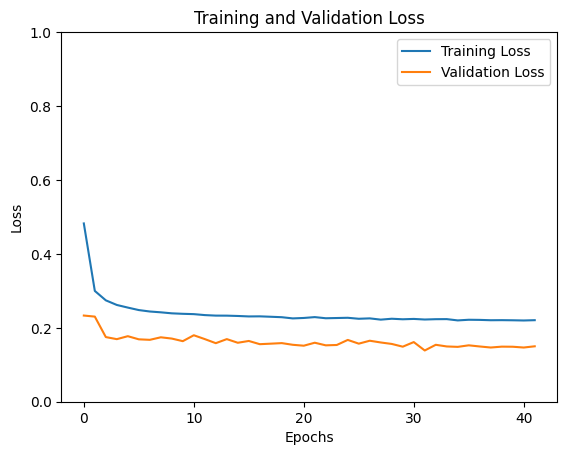

In [ ]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  ax.yaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


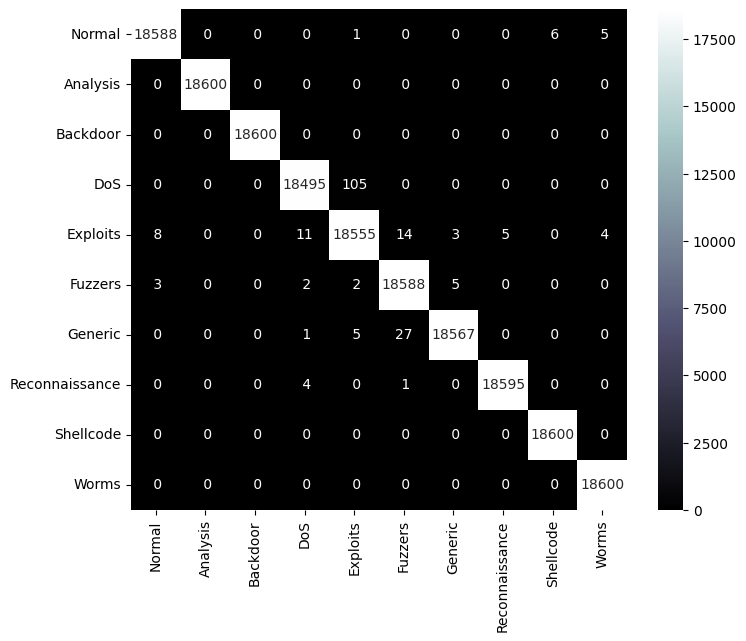

In [ ]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(10), labels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], rotation=45)
plt.yticks(ticks=np.arange(10), labels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], yticklabels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

In [ ]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="gist_yarg",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.85)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  ax.yaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-LSTM Model


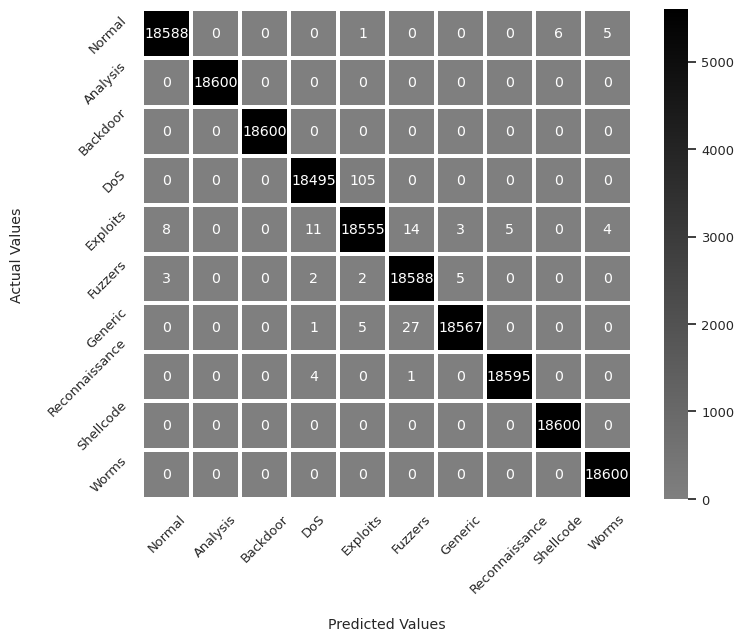

In [ ]:
print("Confusion Matrix of Federated DL// MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)

**Federated Learning Simulation (FedAvg)**

In [ ]:
# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    # Split training data among clients
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    # Initialize the global model
    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the global model
    global_weights = global_model.get_weights()

    for round in range(10):  # Simulate 10 communication rounds
        local_weights = []

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the local model

            # Train the local model
            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"Round {round + 1}: Global Model Accuracy = {acc:.10f}")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)

Round 1: Global Model Accuracy = 0.9881021380
Round 2: Global Model Accuracy = 0.9971666932
Round 3: Global Model Accuracy = 0.9969838858
Round 4: Global Model Accuracy = 0.9971451759
Round 5: Global Model Accuracy = 0.9967580438
Round 6: Global Model Accuracy = 0.9972043037
Round 7: Global Model Accuracy = 0.9977580905
Round 8: Global Model Accuracy = 0.9978548288
Round 9: Global Model Accuracy = 0.9960053563
Round 10: Global Model Accuracy = 0.9973978400


In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to measure model performance
def evaluate_global_model(global_model, X_test, y_test):
    y_pred = global_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute performance metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.10f}")
    print(f"Precision: {precision:.10f}")
    print(f"Recall: {recall:.10f}")
    print(f"F1-Score: {f1:.10f}")
    print("\nConfusion Matrix:")
    print(cm)

    return accuracy, precision, recall, f1

# Function to analyze communication overhead
def analyze_communication_overhead(local_weights, global_weights):
    communication_cost = 0
    for i in range(len(local_weights)):
        # Compute the size of weights transmitted between clients and server
        communication_cost += sum(w.nbytes for w in local_weights[i])
    communication_cost += sum(w.nbytes for w in global_weights)

    print(f"\nCommunication Overhead: {communication_cost / (1024 ** 2):.2f} MB")  # in megabytes

# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    global_weights = global_model.get_weights()

    communication_overhead = []
    latency_per_round = []

    for round in range(10):  # Simulate 10 communication rounds
        local_weights = []

        start_time = time.time()  # Start measuring latency

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Measure latency
        end_time = time.time()
        latency = end_time - start_time
        latency_per_round.append(latency)

        # Measure communication overhead
        analyze_communication_overhead(local_weights, global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"\nRound {round + 1}: Global Model Accuracy = {acc:.10f}")

        # Evaluate model performance metrics
        evaluate_global_model(global_model, X_test, y_test)

    # Summarize overall latency
    print("\nLatency Analysis:")
    print(f"Average Latency per Round: {np.mean(latency_per_round):.2f} seconds")
    print(f"Total Latency for 10 Rounds: {np.sum(latency_per_round):.2f} seconds")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.38 MB

Round 1: Global Model Accuracy = 0.9067742229
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

Model Performance Metrics:
Accuracy: 0.9067741935
Precision: 0.9487173493
Recall: 0.9067741935
F1-Score: 0.8848029893

Confusion Matrix:
[[18600     0     0     0     0     0     0     0     0     0]
 [    0  2047 16553     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    0     0     0 18599     1     0     0     0     0     0]
 [    0     0     0    18 18574     8     0     0     0     0]
 [    0     0     0     0    26 18483    91     0     0     0]
 [    0     0     0     1     5   313 18280     1     0     0]
 [    0     0     0     0     0     0     4 18562    16    18]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0   285 18315]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.38 MB

Round 2: Global Model Accuracy = 0.9970322847
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

Model Performance Metrics:
Accuracy: 0.9970322581
Precision: 0.9970620787
Recall: 0.9970322581
F1-Score: 0.9970321647

Confusion Matrix:
[[18600     0     0     0     0     0     0     0     0     0]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    0     0     0 18490   110     0     0     0     0     0]
 [    0     0     0    10 18584     6     0     0     0     0]
 [    0     0     0     0     4 18555    41     0     0     0]
 [    1     0     0     0     4   345 18248     2     0     0]
 [    0     0     0     0     1     0     4 18571    20     4]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.38 MB

Round 3: Global Model Accuracy = 0.9976774454
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

Model Performance Metrics:
Accuracy: 0.9976774194
Precision: 0.9977100224
Recall: 0.9976774194
F1-Score: 0.9976775486

Confusion Matrix:
[[18600     0     0     0     0     0     0     0     0     0]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    0     0     0 18566    34     0     0     0     0     0]
 [    0     0     0     8 18581     6     4     0     0     1]
 [    0     0     0     0     0 18589    11     0     0     0]
 [    0     0     0     0     0   347 18253     0     0     0]
 [    0     0     0     0     0     0     4 18579    17     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.38 MB

Round 4: Global Model Accuracy = 0.9975322485
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Model Performance Metrics:
Accuracy: 0.9975322581
Precision: 0.9975565006
Recall: 0.9975322581
F1-Score: 0.9975325416

Confusion Matrix:
[[18600     0     0     0     0     0     0     0     0     0]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    3     0     0 18525    72     0     0     0     0     0]
 [    1     1     1    38 18545    14     0     0     0     0]
 [    0     0     0     0     4 18587     9     0     0     0]
 [    1     0     0     0     2   290 18307     0     0     0]
 [    0     0     0     0     0     0     5 18577    18     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.38 MB

Round 5: Global Model Accuracy = 0.9969892502
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Model Performance Metrics:
Accuracy: 0.9969892473
Precision: 0.9970137166
Recall: 0.9969892473
F1-Score: 0.9969898936

Confusion Matrix:
[[18600     0     0     0     0     0     0     0     0     0]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    1     0     0 18438   132     0    29     0     0     0]
 [    0     0     0     8 18516    33    43     0     0     0]
 [    0     0     0     0     0 18592     8     0     0     0]
 [    1     0     0     0     0   284 18315     0     0     0]
 [    0     0     0     0     0     0     4 18579    17     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.38 MB

Round 6: Global Model Accuracy = 0.9975322485
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Model Performance Metrics:
Accuracy: 0.9975322581
Precision: 0.9975557027
Recall: 0.9975322581
F1-Score: 0.9975325231

Confusion Matrix:
[[18600     0     0     0     0     0     0     0     0     0]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    0     0     0 18455   139     0     6     0     0     0]
 [    0     0     0     0 18585    12     1     0     0     2]
 [    0     0     0     0     1 18589    10     0     0     0]
 [    0     0     0     0     0   256 18344     0     0     0]
 [    0     0     0     0     0     0     4 18568    28     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.38 MB

Round 7: Global Model Accuracy = 0.9978656173
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

Model Performance Metrics:
Accuracy: 0.9978655914
Precision: 0.9978780848
Recall: 0.9978655914
F1-Score: 0.9978662825

Confusion Matrix:
[[18600     0     0     0     0     0     0     0     0     0]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    0     3     0 18485    94     0    18     0     0     0]
 [    0     1     0     3 18532    41    23     0     0     0]
 [    0     0     0     0     0 18591     9     0     0     0]
 [    0     0     0     0     1   184 18414     0     0     1]
 [    0     0     0     0     0     0     5 18581    14     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.38 MB

Round 8: Global Model Accuracy = 0.9974139929
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

Model Performance Metrics:
Accuracy: 0.9974139785
Precision: 0.9974420872
Recall: 0.9974139785
F1-Score: 0.9974140663

Confusion Matrix:
[[18600     0     0     0     0     0     0     0     0     0]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    1     0     0 18480   107     0    12     0     0     0]
 [    0     0     0     8 18577    10     3     0     0     2]
 [    0     0     0     0     0 18591     9     0     0     0]
 [    1     0     0     0     0   309 18290     0     0     0]
 [    0     0     0     0     0     0     5 18581    14     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.38 MB

Round 9: Global Model Accuracy = 0.9953763485
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Model Performance Metrics:
Accuracy: 0.9953763441
Precision: 0.9954941490
Recall: 0.9953763441
F1-Score: 0.9953884936

Confusion Matrix:
[[18600     0     0     0     0     0     0     0     0     0]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    1     0     0 18474    97     0    28     0     0     0]
 [    0     0     0     2 18091   502     5     0     0     0]
 [    3     0     0     0     0 18588     9     0     0     0]
 [    1     0     0     0     0   191 18408     0     0     0]
 [    0     0     0     0     0     0     5 18579    16     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Communication Overhead: 0.38 MB

Round 10: Global Model Accuracy = 0.9981558919
5813/5813 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Model Performance Metrics:
Accuracy: 0.9981559140
Precision: 0.9981665603
Recall: 0.9981559140
F1-Score: 0.9981567287

Confusion Matrix:
[[18600     0     0     0     0     0     0     0     0     0]
 [    0 18600     0     0     0     0     0     0     0     0]
 [    0     0 18600     0     0     0     0     0     0     0]
 [    0     0     1 18477   122     0     0     0     0     0]
 [    0     0     0     5 18546    49     0     0     0     0]
 [    0     0     0     0     0 18594     6     0     0     0]
 [    1     0     0     0     2   123 18474     0     0     0]
 [    0     0     0     0     3     0     2 18566    29     0]
 [    0     0     0     0     0     0     0     0 18600     0]
 [    0     0     0     0     0     0     0     0     0 18600]]

Latency Analysis:
Average Latency per Round: 48.08 seconds
Total Latency for 10 Rounds: 480.83 seconds
